In [22]:
from PIL import Image
import numpy as np

img = Image.open('road.jpg')
img = np.array(img)
img
img.shape

(2421, 4303, 3)

In [23]:
from tqdm import tqdm

def filter(image, kernel_size):
    new_image = np.zeros(image.shape, dtype='int')
    print(new_image.shape)
    for i in tqdm(range(image.shape[0])):
        for j in range(image.shape[1]):
            start_y = 0 if i-kernel_size//2 < 0 else i-kernel_size//2
            end_y = new_image.shape[0] - 1 if i+kernel_size//2 > new_image.shape[0] + 1 else i+kernel_size//2 + 1

            start_x = 0 if j-kernel_size//2 < 0 else j-kernel_size//2
            end_x = new_image.shape[1] - 1 if j+kernel_size//2 > new_image.shape[1] + 1 else j+kernel_size//2 + 1

            new_image[i, j, :] = int(np.sum(image[start_y:end_y, start_x:end_x, 0])/((end_y-start_y)*(end_x-start_x)))
    return new_image

In [24]:
def to_gray_scale(image):
    for i in tqdm(range(image.shape[0])):
        for j in range(image.shape[1]):
            image[i, j, :] = np.mean(image[i, j, :])
    return image[:, :, :]

In [25]:
import matplotlib.pyplot as plt

%matplotlib inline

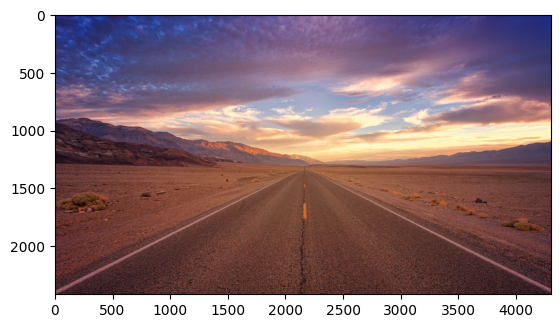

In [26]:
plt.imshow(img)

100%|██████████| 2421/2421 [00:28<00:00, 84.15it/s]


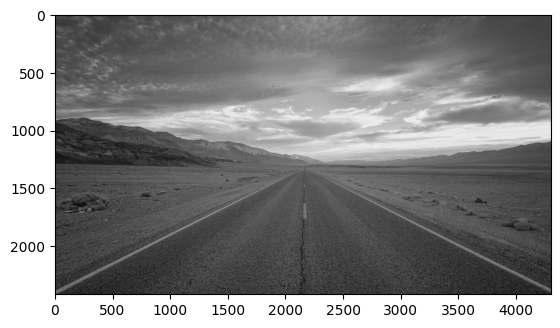

In [9]:
gray_img = to_gray_scale(img)
plt.imshow(gray_img)

In [27]:
filtered_image = filter(gray_img, 71)
filtered_image.shape

(2421, 4303, 3)


100%|██████████| 2421/2421 [01:09<00:00, 34.96it/s]


(2421, 4303, 3)

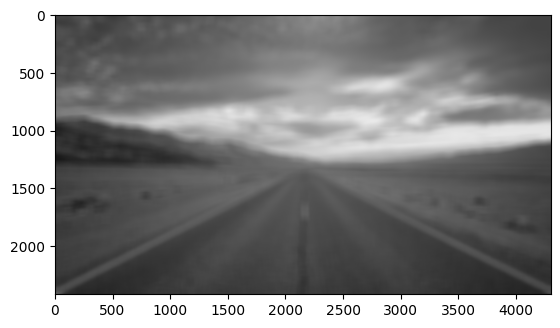

In [152]:
plt.imshow(filtered_image, 'gray')

In [28]:
def smt(image):
    return image.cumsum(axis=0).cumsum(axis=1)

In [31]:
def filter_with_smt(image, kernel_size):
    new_image = np.zeros(image.shape, dtype='uint8')
    t = smt(image)
    # print(t.dtype)
    t = t.astype(np.int64)
    half_of_mask = kernel_size//2

    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            ax, ay = max(0, j - half_of_mask), max(0, i - half_of_mask)
            bx, by = min(j + half_of_mask, image.shape[1]-1), max(0, i - half_of_mask)
            cx, cy = max(0, j - half_of_mask), min(image.shape[0]-1, i + half_of_mask)
            dx, dy = min(image.shape[1]-1, j + half_of_mask), min(image.shape[0]-1, i + half_of_mask)

            A = t[ay, ax, 0]
            B = t[by, bx, 0]
            C = t[cy, cx, 0]
            D = t[dy, dx, 0]
            new_image[i][j] = ((D - B - C + A)/((bx-ax)*(cy-ay)))
    return new_image

In [32]:
filtered_img_using_smt = filter_with_smt(gray_img, 71)

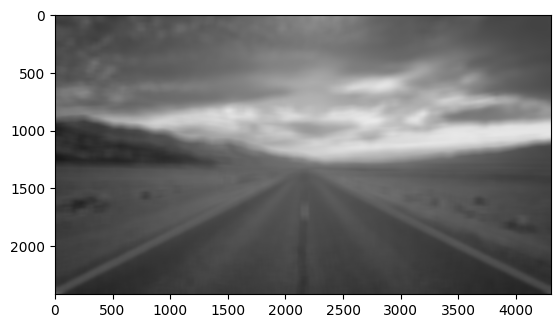

In [259]:
plt.imshow(filtered_img_using_smt, 'gray')

In [121]:
def single_thresholding(img, thr):
    new_img = np.zeros(img.shape)
    for i in tqdm(range(img.shape[0])):
        for j in range(img.shape[1]):
            if img[i][j][0] > thr:
                new_img[i][j][:] = 255
            else:
                new_img[i][j][:] = 0
    return new_img

100%|██████████| 2421/2421 [00:11<00:00, 205.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


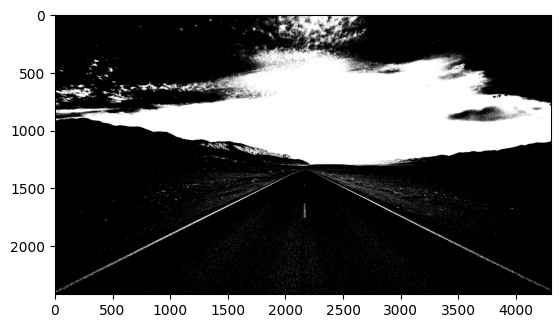

In [122]:
sthr = single_thresholding(gray_img, 125)
plt.imshow(sthr)

In [130]:
def double_thresholding(img, thr1, thr2):
    new_img = np.zeros(img.shape)
    for i in tqdm(range(img.shape[0])):
        for j in range(img.shape[1]):
            if img[i][j][0] > thr1:
                new_img[i][j][:] = 255
            elif img[i][j][0] < thr2:
                new_img[i][j][:] = 0
            else:
                new_img[i][j][:] = 255
    return new_img

100%|██████████| 2421/2421 [00:19<00:00, 121.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


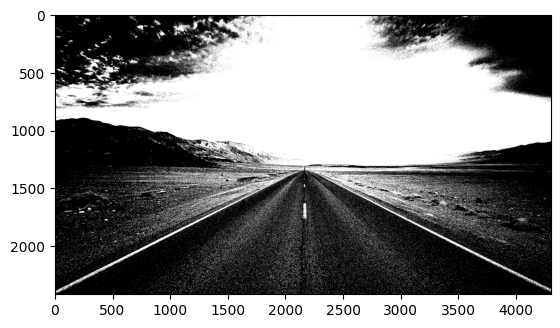

In [131]:
dthr = double_thresholding(gray_img, 200, 100)
plt.imshow(dthr)

In [341]:
test_pixels = [52, 55,	61,	59,	79,	61,	76,	61,
62,	59,	55,	104	,94,	85,	59,	71,
63,	65,	66,	113	,144,	104,	63,	72,
64,	70,	70,	126	,154,	109	,71,	69,
67,	73,	68,	106, 122,	88,	68,	68,
68,	79,	60,	70,	77,	66,	58,	75,
69,	85,	64,	58,	55,	61,	65,	83,
70,	87,	69,	68,	65,	73,	78,	90]

test_image = np.zeros((8, 8, 3))

c = 0
for i in range(8):
    for j in range(8):
        test_image[i,j,:] = test_pixels[c]
        c += 1

test_image = np.array(test_image)

In [346]:
def get_cumsum(img):
    unique_pixels = np.sort(np.unique(img))
    count = []
    for pixel in unique_pixels:
        count.append(np.count_nonzero(pixel == img[:, :, 0]))
    return unique_pixels, np.cumsum(count)

def cdf(v, unique_pixels, cumsum):
    idx = np.where(unique_pixels==v)[0][0]
    return cumsum[idx]

def h(cdf_v, cdf_min, shape):
    return np.round((cdf_v - cdf_min)*255/(shape[0]*shape[1]-cdf_min))

def contrast(img):
    shape = img.shape
    new_image = np.zeros(shape, dtype=np.int64)
    unique_pixels, cumsum = get_cumsum(img)
    cdf_min = cumsum[0]
    for i in range(shape[0]):
        for j in range(shape[1]):
            cdf_v = cdf(img[i, j, 0], unique_pixels, cumsum)
            new_image[i, j, :] = h(cdf_v, cdf_min, shape)
    return new_image.reshape(shape)

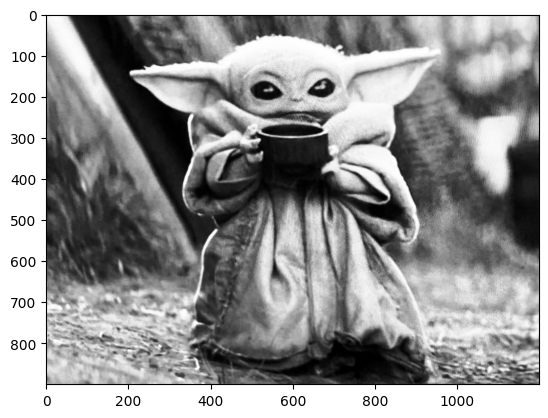

In [347]:
contrasted = contrast(img)
plt.imshow(contrasted)

In [268]:
filtered_img_using_smt = filtered_img_using_smt.astype('uint8')

plt.imsave("filtered_img_using_smt.png", filtered_img_using_smt)

In [126]:
filtered_image = filtered_image.astype('uint8')

plt.imsave("filtered_image.png", filtered_image)

In [127]:
gray_img = gray_img.astype('uint8')

plt.imsave("gray_img.png", gray_img)

In [128]:
sthr = sthr.astype('uint8')

plt.imsave("sthr.png", sthr)

In [129]:
dthr = dthr.astype('uint8')

plt.imsave("dthr.png", dthr)

In [ ]:
contrasted = contrasted.astype('uint8')

plt.imsave("dthr.png", contrasted)